In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [157]:
# !pip install statsmodels

In [158]:
df = pd.read_excel("../data/brote_dengue.xlsx")
df.columns = ["Temp_Seca_Max","Precipitacion","Temp_Seca_Min","Hum_Rel_Min","Hum_Rel_Max","brote","Dengue"]
df = df[["Temp_Seca_Max","Precipitacion","Temp_Seca_Min","Hum_Rel_Min","Hum_Rel_Max","Dengue"]]
df = df.dropna()
df

,Temp_Seca_Max,Precipitacion,Temp_Seca_Min,Hum_Rel_Min,Hum_Rel_Max,Dengue
0,25.866667,3.700000,19.433333,47.500000,91.666667,2
1,28.200000,0.000000,20.800000,40.833333,91.333333,2
2,29.066667,0.033333,20.933333,45.333333,94.333333,1
3,30.266667,11.133333,20.500000,57.833333,92.000000,1
4,28.133333,1.016667,18.600000,50.833333,89.166667,2
...,...,...,...,...,...,...
93,28.200000,2.783333,20.066667,46.833333,86.500000,22
94,27.066667,7.050000,20.966667,49.500000,87.666667,18
95,28.933333,4.350000,20.933333,44.166667,87.666667,17
96,29.933333,0.733333,20.700000,45.000000,87.500000,14


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


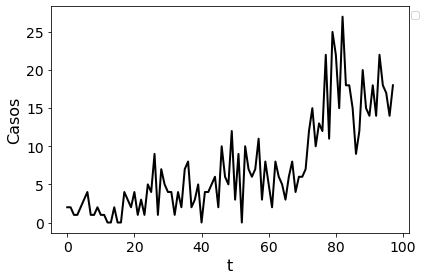

In [159]:
values = df.Temp_Seca_Max.values
xx = np.arange(values.shape[0])
plt.plot(xx,df["Dengue"].values, 
         c="k",
        #  marker = 'o',
         linewidth=2,
         markersize=6
         )

plt.legend(bbox_to_anchor = (1.04,1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('t', fontsize = 16)    
plt.ylabel('Casos', fontsize = 16)  
plt.tight_layout()
plt.savefig("outputs/series_casos_dengue.pdf", dpi = 200)
plt.show()

In [211]:
def linear_regressor_with(df,slag, seed = 42, shuffle = True):
    X = df[["Temp_Seca_Max","Precipitacion","Temp_Seca_Min","Hum_Rel_Min","Hum_Rel_Max"]].values
    y = df["Dengue"].values

    n_samples,n_features = X.shape

    #Se hace el ventaneo para obtener los datos de entrenamiento
    new_X = []
    for i in range(0,n_samples - slag ):
        X_raveled = X[i:i+slag,:].ravel()
        new_X.append(X_raveled)
    new_X = np.array(new_X)
    new_y = y[slag:]

    # print(f'Utilizando un Slag de {slag} tenemos X: {new_X.shape} y: {new_y.shape}')
    X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, 
                                                        test_size=0.20, 
                                                        random_state=seed,
                                                        shuffle = shuffle)
    ind_train, ind_test = train_test_split(np.arange(new_X.shape[0]),
                                                        test_size=0.20, 
                                                        random_state=seed,
                                                        shuffle = shuffle)
    
    #Estadistico
    est = sm.OLS(y_train,sm.add_constant(X_train)).fit()
    aic_score = est.aic
    bic_score = est.bic
    # print(f'------------- {slag} ----------')
    # print(f'AIC: {est.aic}')
    # print(f'BIC: {est.bic}')
    # print(est.summary())
    
    #Sklearn
    # print(f'Test (20%): {X_test.shape[0]}')
    
    #train
    clf = LinearRegression().fit(X_train, y_train)    
    score_train = clf.score(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    score_train_adjusted = 1 - ( 1-score_train ) * ( y_train.shape[0] - 1 ) / ( y_train.shape[0] - X_train.shape[1] - 1 )
    print(f'score during training: {score_train} || Adjusted: {score_train_adjusted} || MSE: {mean_squared_error(y_train,y_train_pred)}')
    
    
    #test
    y_test_pred = clf.predict(X_test)
    score_test = clf.score(X_test, y_test)
    mse = mean_squared_error(y_test,y_test_pred)
    print(f'score during test: {score_test} || MSE: {mse}')
    # coefs = clf.coef_
    return ind_train, ind_test, y_train, y_train_pred, y_test, y_test_pred, score_train_adjusted, mse, aic_score, bic_score

score during training: 0.13411915969308674 || Adjusted: 0.0731416357278113 || MSE: 13.880673022062892
score during test: -7.2870255811155005 || MSE: 162.34283113405266


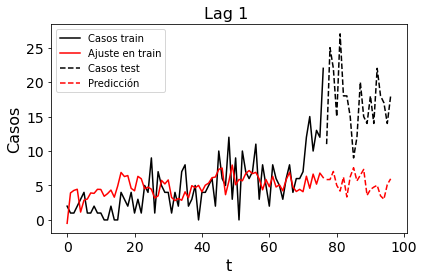

In [212]:
ind_train, ind_test, y_train, y_train_pred, y_test, y_test_pred, r2, mse, aic_score, bic_score= linear_regressor_with(df,1,shuffle=False)

plt.plot(ind_train,y_train, c="k", label="Casos train")
plt.plot(ind_train,y_train_pred, c="r", label = "Ajuste en train")

plt.plot(ind_test,y_test, c="k", linestyle="--", label = "Casos test")
plt.plot(ind_test,y_test_pred, c="r", linestyle="--", label = "Predicción")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('t', fontsize = 16)    
plt.ylabel('Casos', fontsize = 16)  
plt.title("Lag 1 ", fontsize = 16)
plt.legend()
plt.tight_layout()
# plt.savefig("outputs/linearReg_lag1.pdf", dpi = 200)

In [201]:
def varying_slag(li, ls, step = 1, shuffle = True):
    performance = {"slag":[], 
                "r2-ajustado":[], 
                "test MSE": [],
                "AIC":[], 
                "BIC": []}
    for i in range(li,ls,step):
        performance["slag"].append(i)
        ind_train, ind_test, y_train, y_train_pred, y_test, y_test_pred, r2, mse,aic_score, bic_score = linear_regressor_with(df, 
                                    slag = i, 
                                    shuffle = shuffle)
        performance["r2-ajustado"].append(r2)
        performance["test MSE"].append(mse)
        performance["AIC"].append(aic_score)
        performance["BIC"].append(bic_score)
    performance = pd.DataFrame(performance)
    performance["sem"] = performance["slag"] / 7
    return performance

    
def plot_performance(performance, col, ylabel, figsize = (6,4), log_scale = False):
    fig, ax = plt.subplots(figsize=figsize)
    plt.grid()
    plt.plot(performance["slag"],performance[col], 
             linewidth = 2.5, 
            #  c = "#F37B01",
             marker = 'o',
             markersize = 8)
    ax.set_xticks(list(performance["slag"]))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if log_scale == True:
        plt.yscale("log")    
    plt.xlabel('Lag', fontsize = 16)    
    plt.ylabel(ylabel, fontsize = 16)  
    plt.tight_layout()    

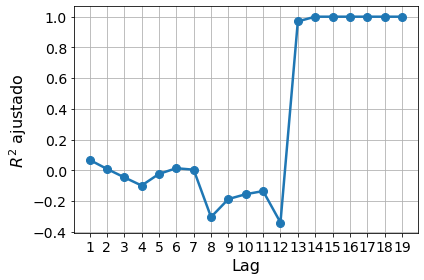

In [141]:
performance = varying_slag(li=1,ls=20,step=1,shuffle=True)
plot_performance(performance, 
                 col = "r2-ajustado",
                 ylabel = r'$R^2$ ajustado')
plt.savefig("outputs/linerreg_r2_ajusted.pdf", dpi = 200)
plt.show()


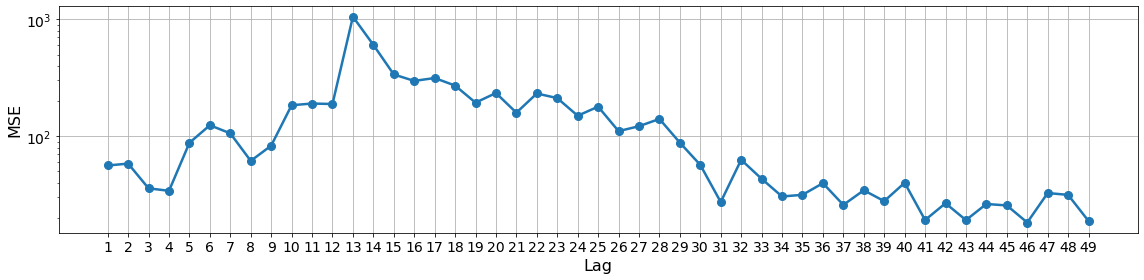

In [208]:
performance = varying_slag(li=1,ls=50,step=1,shuffle=True)
plot_performance(performance, 
                 col = "test MSE",
                 ylabel = "MSE",
                 figsize = (16,4), 
                 log_scale = True)
plt.savefig("outputs/linerreg_mse.pdf", dpi = 200)
plt.show()

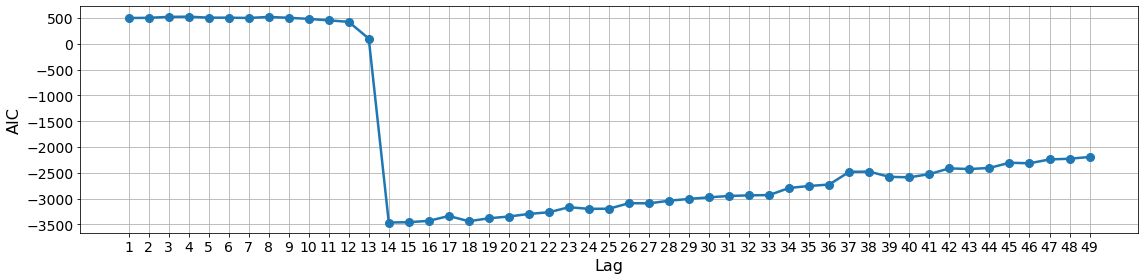

In [203]:
performance = varying_slag(li=1,ls=50,step=1,shuffle=True)
plot_performance(performance, 
                 col = "AIC",
                 ylabel = "AIC",
                 figsize = (16,4), 
                 log_scale = False)
plt.savefig("outputs/linear_reg_AIC.pdf", dpi = 200)
plt.show()

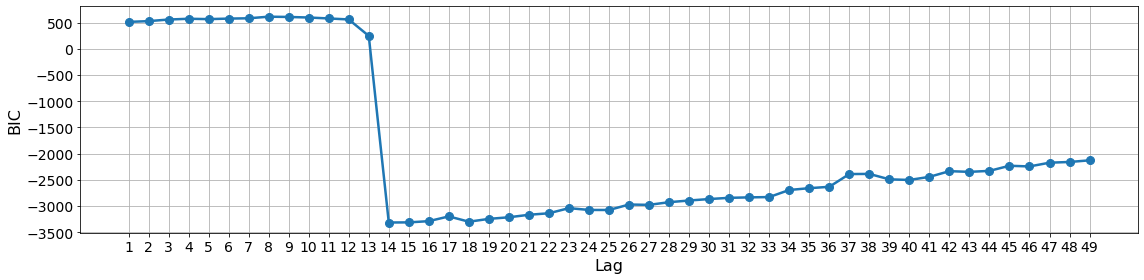

In [204]:
performance = varying_slag(li=1,ls=50,step=1,shuffle=True)
plot_performance(performance, 
                 col = "BIC",
                 ylabel = "BIC",
                 figsize = (16,4), 
                 log_scale = False)
plt.savefig("outputs/linear_reg_BIC.pdf", dpi = 200)
plt.show()

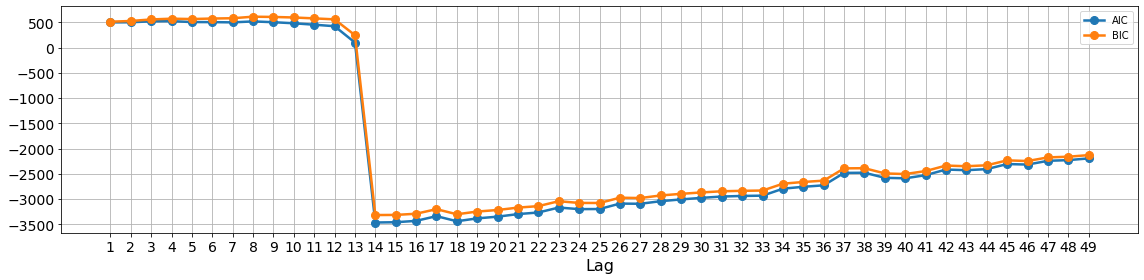

In [206]:
fig, ax = plt.subplots(figsize=(16,4))
plt.grid()
plt.plot(performance["slag"],performance["AIC"], 
            linewidth = 2.5, 
        #  c = "#F37B01",
            marker = 'o',
            markersize = 8,
            label = "AIC")

plt.plot(performance["slag"],performance["BIC"], 
            linewidth = 2.5, 
        #  c = "#F37B01",
            marker = 'o',
            markersize = 8,
            label = "BIC")

ax.set_xticks(list(performance["slag"]))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
  
plt.xlabel('Lag', fontsize = 16)    
# plt.ylabel(ylabel, fontsize = 16)  
plt.legend()
plt.tight_layout()    
plt.savefig("outputs/linear_reg_AIC_BIC.pdf", dpi = 200)